In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 4.05 μs


In [4]:
# configuration settings

data_root = '/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene'
data_name = 'copdgene'
mask_roi = 'lung_regions'
mesh_version = 10

input_anat = True
input_coords = False

model_arch = 'unet3d'
num_levels = 3
num_conv_layers = 2
conv_channels = 32
conv_kernel_size = 3
output_func = 'relu'

trainer_task = 'train'
rho_value = 'anat'
interp_size = 5
interp_type = 'tent'
batch_size = 1
learning_rate = 1e-5
num_epochs = 200
test_every = 10
save_every = 10
save_prefix = '2024-02-24_miccai2025/asdf'

#save_prefix = f'2024-12-08__emory__clamp/train__emory__None__0__{rho_value}__{output_func}/'

In [5]:
project.utils.set_random_seed()

Setting random seed to 446897325


In [6]:
all_subjects = project.copdgene.COPDGene(data_root).subject_ids
bad_subjects = {
    '11771K', # no EXP image
    '12723E', # no EXP image
    '13990G', # no EXP image
    '14136Z', # no EXP image
    '15626V', # no EXP image
}
good_subjects = [x for x in all_subjects if x not in bad_subjects]

train_subjects = good_subjects[10:]
test_subjects = good_subjects[:10]
visit_names = ['Phase-1']

train_images = project.copdgene.COPDGene(data_root, train_subjects, visit_names)
test_images  = project.copdgene.COPDGene(data_root, test_subjects, visit_names)
train_images, test_images

(COPDGene(data_root=/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene, #subjects=100),
 COPDGene(data_root=/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene, #subjects=10))

In [7]:
%autoreload
train_examples = train_images.get_examples()
test_examples = test_images.get_examples()
for x in train_examples:
    for f in ['anat_file', 'disp_file', 'mask_file', 'mesh_file']:
        assert x[f].exists(), x[f]

In [8]:
%autoreload
train_data = project.data.Dataset(train_examples, scale=(1,1,4), use_cache=False)
test_data = project.data.Dataset(test_examples, scale=(1,1,4), use_cache=False)

In [9]:
device = 'cuda'
assert model_arch == 'unet3d'

model = project.model.UNet3D(
    in_channels=1*input_anat + 3*input_coords,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
    output_func=output_func,
).to(device)

In [10]:
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    rho_value=rho_value,
    interp_size=interp_size,
    interp_type=interp_type,
    test_every=test_every,
    save_every=save_every,
    save_prefix=save_prefix
)

In [11]:
load_epoch = 0
if load_epoch > 200:
    trainer.load_state(epoch=load_epoch)

In [18]:
j, batch = trainer.get_next_batch(phase='train')
batch[-1]

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/11049P/Phase-1/Resized/11049P_EXP_STD_NJC_COPD.nii.gz... (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/11049P/Phase-1/CorrField/11049P_EXP_STD_NJC_COPD/11049P_INSP_STD_NJC_COPD.nii.gz... (256, 256, 256, 3)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/11049P/Phase-1/TotalSegment/11049P_EXP_STD_NJC_COPD/lung_regions.nii.gz... (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/11049P/Phase-1/pygalmesh/11049P_EXP_STD_NJC_COPD/lung_regions_10.xdmf... 22067


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../project/training.py:561: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/torch/csrc/utils/tensor_new.cpp:278.)
  res  = torch.as_tensor([ex[5] for ex in batch])


['11049P_EXP_STD_NJC_COPD']

In [19]:
batch[0].shape

torch.Size([1, 1, 256, 256, 64])

In [29]:
%autoreload
import torch

def check_nan(**kwargs):
    for k, v in kwargs.items():
        assert not torch.isnan(v).any(), f'{v} contains nan'

# manual forward pass
a_image, e_image, u_image, mask, disease_mask, resolution, pde, name = batch

check_nan(a_image=a_image, e_image=e_image, u_image=u_image, mask=mask, disease_mask=disease_mask)

a_image = a_image.to(device)
e_image = e_image.to(device)
u_image = u_image.to(device)
mask = (mask > 0).to(device)

e_pred_image = model.forward(a_image) * 1000
e_pred_image = e_pred_image.clamp(min=1, max=1e12)

points = pde[0].points.to(device)
radius = pde[0].radius.to(device)

a_dofs = project.interpolation.interpolate_image(
    a_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

rho_dofs = (a_dofs + 1000)

e_pred_dofs = project.interpolation.interpolate_image(
    e_pred_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

u_true_dofs = project.interpolation.interpolate_image(
    u_image[0], mask[0], resolution[0], points, radius,
    kernel_size=interp_size,
    kernel_type=interp_type,
).to(dtype=torch.float64, device='cpu')

check_nan(u_true_dofs=u_true_dofs, e_pred_dofs=e_pred_dofs, rho_dofs=rho_dofs)

u_pred_dofs = pde[0].forward(
    u_true_dofs[None,:,:],
    e_pred_dofs[None,:,0],
    rho_dofs[None,:,0]
)[0]

check_nan(u_pred_dofs=u_pred_dofs)

u_pred_dofs.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 47.43 GiB of which 19.69 MiB is free. Including non-PyTorch memory, this process has 47.40 GiB memory in use. Of the allocated memory 46.16 GiB is allocated by PyTorch, and 963.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(u_pred_dofs.numel())
print(u_pred_dofs.isnan().sum().item())

In [ ]:
e_pred_dofs[u_pred_dofs.isnan().any(dim=1)]

(14418,) (14418,) (14418,)


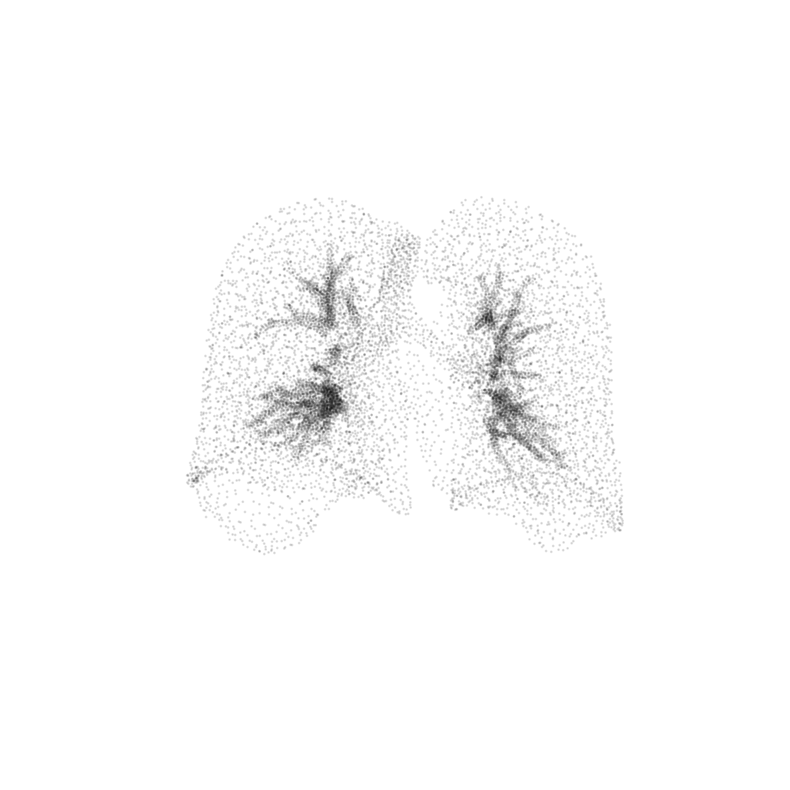

In [17]:
# plot nans

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

eps = 1e-6
values = u_pred_dofs.isnan().any(dim=-1).detach().cpu().numpy().astype(int)
normed = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0) + eps)

c = normed * 1 + 0
s = normed * 5 + 1
a = normed * 0.9 + 0.1
print(c.shape, s.shape, a.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.scatter(x, y, z, c=c, cmap=project.visual.mre_color_map(symmetric=False), s=s, alpha=a)
ax.set_axis_off()

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

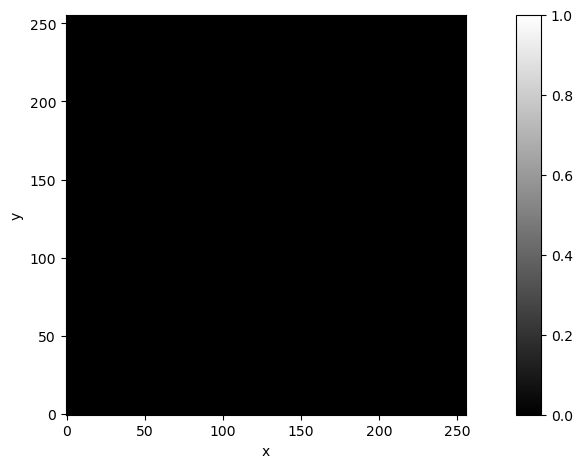

In [18]:
# view mask

project.visual.XArrayViewer(
    project.utils.as_xarray(mask[0,0], dims=['x', 'y', 'z'], name='mask')
)

[[0.77279162 0.1259783  0.78525525]
 [0.77027766 0.12632147 0.78395877]
 [0.77146459 0.13167461 0.7768537 ]
 ...
 [0.44365735 0.20883232 0.817451  ]
 [0.41682534 0.1947431  0.83269129]
 [0.43428798 0.20711754 0.83426343]]


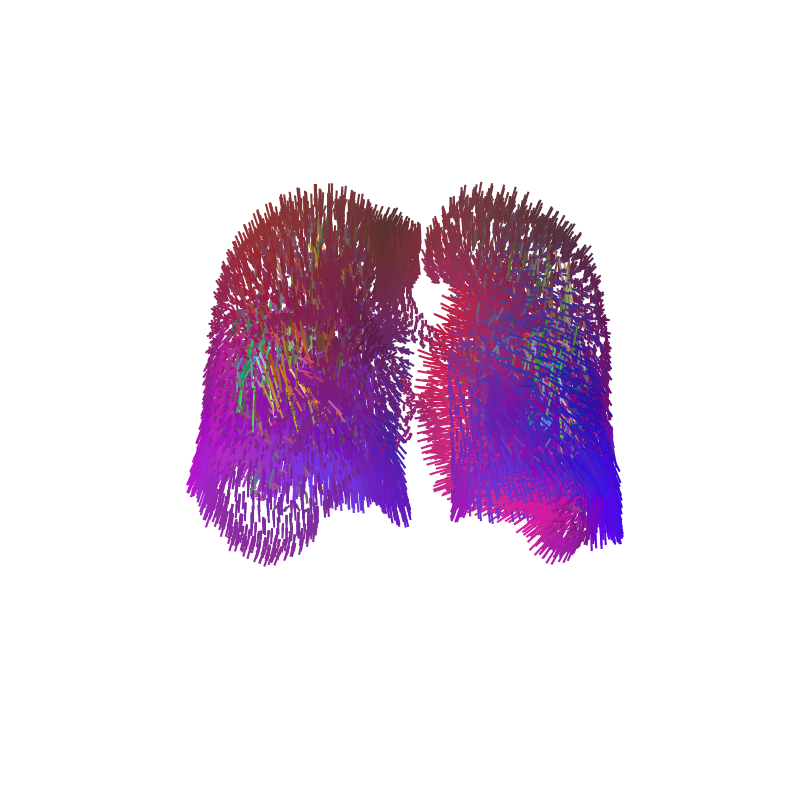

In [19]:
# plot dofs

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
disp = u_pred_dofs.detach().cpu().numpy() * 1

x = coords[:,0]
y = coords[:,1]
z = coords[:,2]
u_x = disp[:,0]
u_y = disp[:,1]
u_z = disp[:,2]

c = (disp - disp.min(axis=0)) / (disp.max(axis=0) - disp.min(axis=0))
print(c)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.quiver(x, y, z, u_x, u_y, u_z, colors=c, arrow_length_ratio=0.5)
ax.set_axis_off()

1.0
[[1.07265892]
 [1.41980416]
 [0.79059855]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
[0.]
[[0.38986297]
 [0.51603456]
 [0.2873468 ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


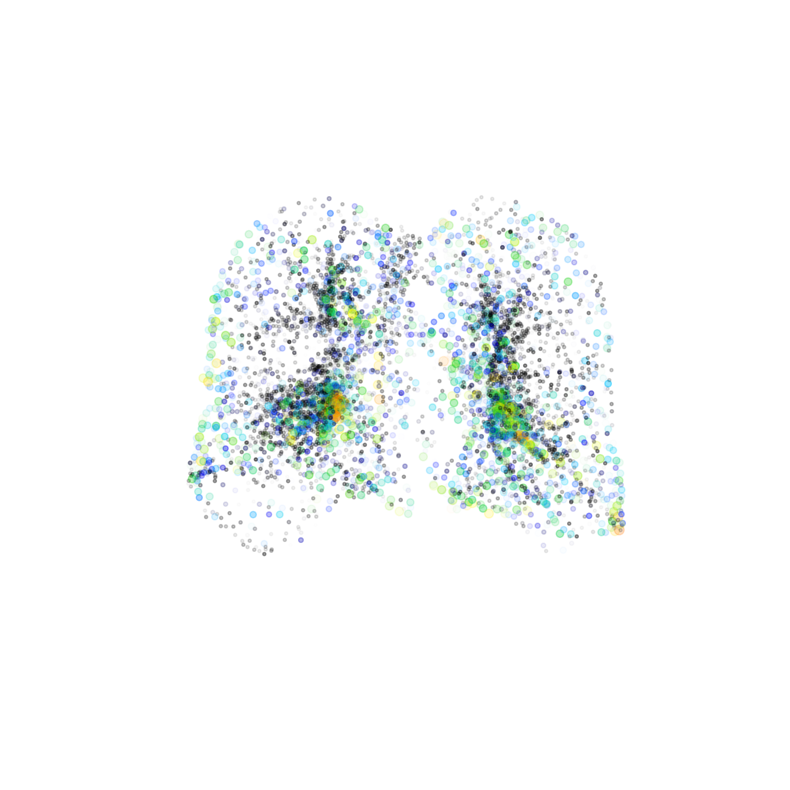

In [20]:
# plot dofs

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

coords = pde[0].points.detach().cpu().numpy()
elast = e_pred_dofs.clamp(1, 1e12).detach().cpu().numpy()
print(elast.min())

log_e = np.log10(elast)
print(log_e)
print(log_e.min(axis=0))

x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

c = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0))
s = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0)) * 50 + 5
a = (log_e - log_e.min(axis=0)) / (log_e.max(axis=0) - log_e.min(axis=0)) / 2
print(c)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-15, azim=-90, roll=0)
q = ax.scatter(x, y, z, c=c, cmap=project.visual.mre_color_map(symmetric=False), s=s, alpha=a)
ax.set_axis_off()

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (1.3816097974777222, 1), (2.76321959…

0.02229002
CPU times: user 2min 43s, sys: 4.98 s, total: 2min 48s
Wall time: 2min 25s


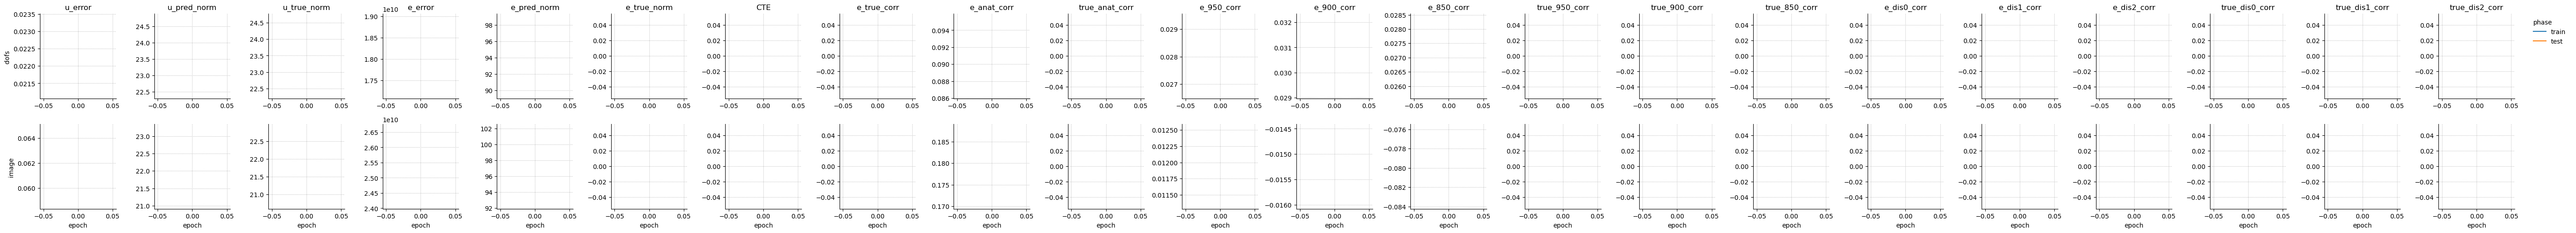

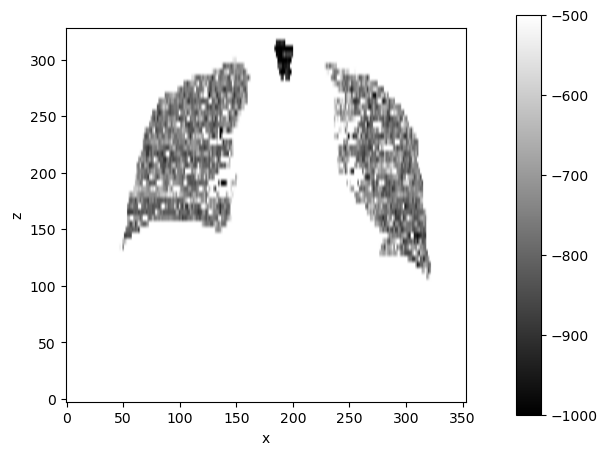

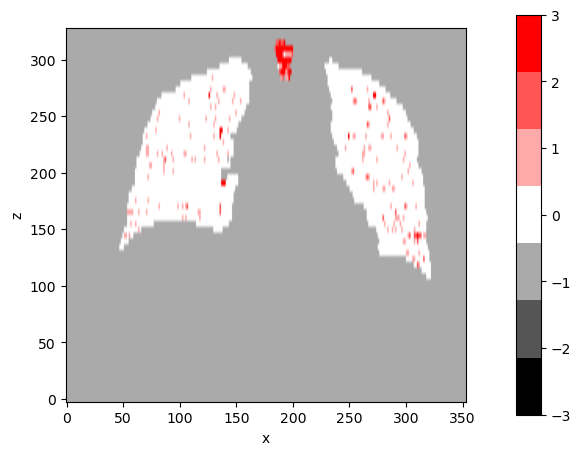

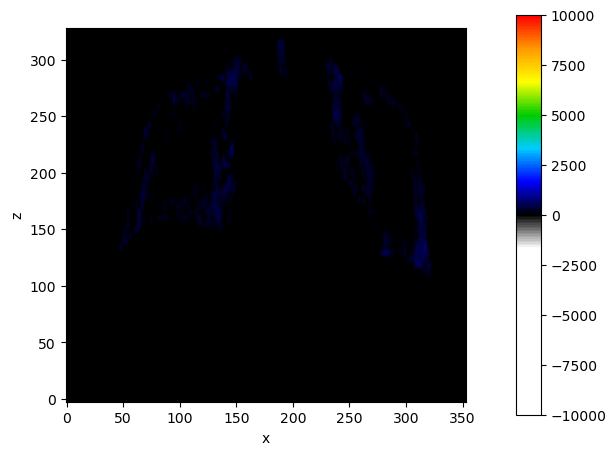

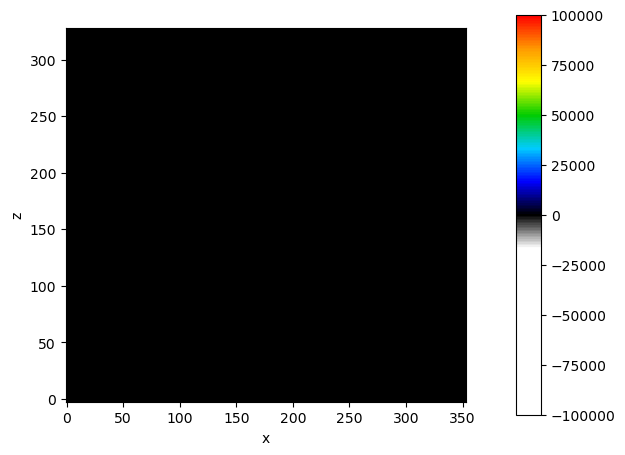

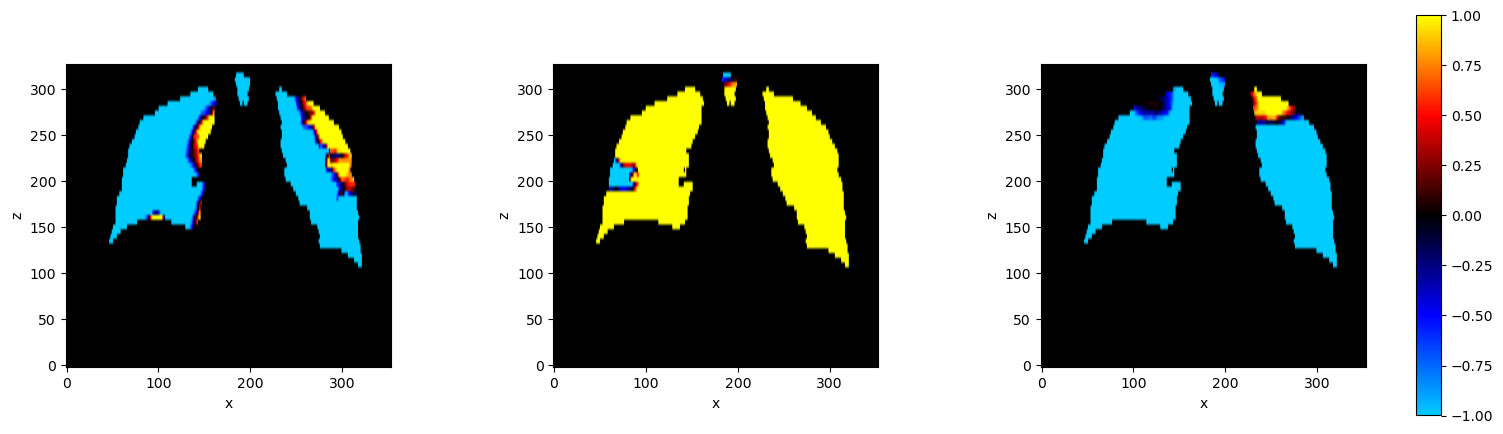

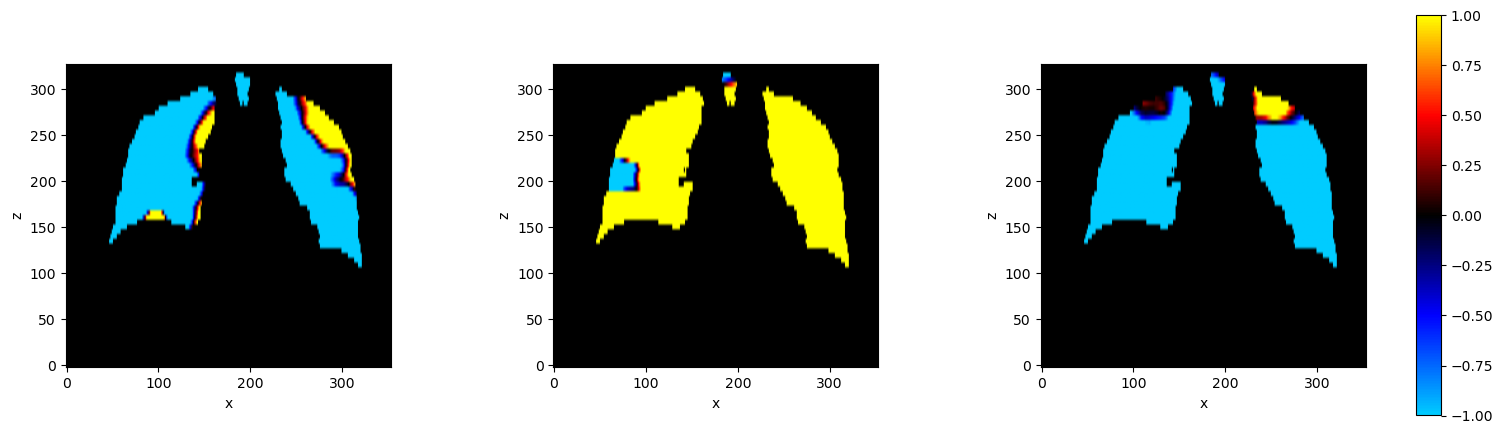

In [12]:
%%time
%autoreload
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=trainer.epoch)

In [13]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=250)

Training...
Epoch 1/250
Running train phase
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/23431C/Phase-1/Resized/23431C_INSP_STD_HAR_COPD.nii.gz... (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/23431C/Phase-1/CorrField/23431C_INSP_STD_HAR_COPD/23431C_EXP_STD_HAR_COPD.nii.gz... (256, 256, 256, 3)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/23431C/Phase-1/TotalSegment/23431C_INSP_STD_HAR_COPD/lung_regions.nii.gz... (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/23431C/Phase-1/pygalmesh/23431C_INSP_STD_HAR_COPD/lung_regions_10.xdmf... 14076
['23431C_INSP_STD_HAR_COPD'].0.00156466
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/20965Y/Phase-1/Resized/20965Y_EXP_STD_TEM_COPD.nii.gz... (256, 256, 256)
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/20965Y/Phase-1/CorrField/2

In [15]:
trainer.evaluator.metrics

u_error u_pred_norm  \
epoch batch example                   phase rep                           
0     1     10285W_EXP_STD_USD_COPD   test  dofs    0.02229   23.591397   
                                            image  0.061725   22.132055   
1     1     23431C_INSP_STD_HAR_COPD  train dofs   0.001565    19.57101   
      2     20965Y_EXP_STD_TEM_COPD   train dofs   0.000833   18.936689   
      3     12167A_INSP_STD_TEM_COPD  train dofs   0.001447   13.341825   
...                                                     ...         ...   
22    155   17495Q_INSP_B35f_NJC_COPD train dofs   0.000599   30.639219   
      156   11170K_INSP_STD_BWH_COPD  train dofs   0.001173   24.822033   
      157   15914A_EXP_STD_UIA_COPD   train dofs   0.000135   20.542105   
      158   24648G_INSP_STD_JHU_COPD  train dofs   0.000427   13.549357   
      159   18200C_INSP_STD_DUK_COPD  train dofs   0.000301   22.004395   

                                                  u_true_norm  \
epoch batch example                   phase rep                 
0     1     10285W_EXP_STD_USD_COPD   test  dofs    23.489112   
                                            image   21.790665   
1     1     23431C_INSP_STD_HAR_COPD  train dofs     19.64658   
      2     20965Y_EXP_STD_TEM_COPD   train dofs    18.896552   
      3     12167A_INSP_STD_TEM_COPD  train dofs    13.389279   
...                                                       ...   
22    155   17495Q_INSP_B35f_NJC_COPD train dofs    30.670444   
      156   11170K_INSP_STD_BWH_COPD  train dofs    24.866253   
      157   15914A_EXP_STD_UIA_COPD   train dofs    20.546896   
      158   24648G_INSP_STD_JHU_COPD  train dofs    13.558697   
      159   18200C_INSP_STD_DUK_COPD  train dofs    22.021238   

                                                                e_error  \
epoch batch example                   phase rep                           
0     1     10285W_EXP_STD_USD_COPD   test  dofs     18072929479.259308   
                                            image         25375899648.0   
1     1     23431C_INSP_STD_HAR_COPD  train dofs     46793411737.543335   
      2     20965Y_EXP_STD_TEM_COPD   train dofs     24832879172.926559   
      3     12167A_INSP_STD_TEM_COPD  train dofs     49824513209.677452   
...                                                                 ...   
22    155   17495Q_INSP_B35f_NJC_COPD train dofs   1805775982075.321533   
      156   11170K_INSP_STD_BWH_COPD  train dofs   1725151419217.722656   
      157   15914A_EXP_STD_UIA_COPD   train dofs   1629249602625.397217   
      158   24648G_INSP_STD_JHU_COPD  train dofs   1826773265773.404541   
      159   18200C_INSP_STD_DUK_COPD  train dofs   1571140407717.996582   

                                                   e_pred_norm e_true_norm  \
epoch batch example                   phase rep                              
0     1     10285W_EXP_STD_USD_COPD   test  dofs     94.214261         0.0   
                                            image     97.25386         0.0   
1     1     23431C_INSP_STD_HAR_COPD  train dofs    182.879935         0.0   
      2     20965Y_EXP_STD_TEM_COPD   train dofs    107.549965         0.0   
      3     12167A_INSP_STD_TEM_COPD  train dofs    173.616264         0.0   
...                                                        ...         ...   
22    155   17495Q_INSP_B35f_NJC_COPD train dofs   1296.524248         0.0   
      156   11170K_INSP_STD_BWH_COPD  train dofs   1272.524506         0.0   
      157   15914A_EXP_STD_UIA_COPD   train dofs   1246.687944         0.0   
      158   24648G_INSP_STD_JHU_COPD  train dofs   1314.665143         0.0   
      159   18200C_INSP_STD_DUK_COPD  train dofs   1225.236339         0.0   

                                                   CTE e_true_corr  \
epoch batch example                   phase rep                      
0     1     10285W_EXP_STD_USD_COPD   test  dofs   NaN         NaN   
                             

In [18]:
trainer.timer.benchmarks

time  gpu_mem_total  \
epoch batch example phase event                                      
0     1     -1      test  get_next_batch  12.762670   5.092894e+10   
                          model_forward    0.649131   5.092894e+10   
             1      test  image_to_dofs    0.004703   5.092894e+10   
                          pde_forward      3.456626   5.092894e+10   
                          dof_metrics      2.795768   5.092894e+10   
...                                             ...            ...   
22    159    1      train image_to_dofs    0.006671   5.092894e+10   
                          pde_forward      0.961437   5.092894e+10   
                          dof_metrics      0.797176   5.092894e+10   
            -1      train loss_backward    1.016834   5.092894e+10   
                          optimizer_step   0.007470   5.092894e+10   

                                          gpu_mem_reserved  gpu_mem_allocated  \
epoch batch example phase event                                                 
0     1     -1      test  get_next_batch      2.516582e+07       5.677568e+06   
                          model_forward       1.455214e+10       1.241575e+10   
             1      test  image_to_dofs       1.701419e+10       1.323392e+10   
                          pde_forward         1.701419e+10       1.323392e+10   
                          dof_metrics         1.701419e+10       1.323392e+10   
...                                                    ...                ...   
22    159    1      train image_to_dofs       2.124625e+10       1.276610e+10   
                          pde_forward         2.124625e+10       1.276610e+10   
                          dof_metrics         2.124625e+10       1.276610e+10   
            -1      train loss_backward       2.124625e+10       2.046070e+08   
                          optimizer_step      2.124625e+10       1.984717e+08   

                                             mem_total      mem_used  
epoch batch example phase event                                       
0     1     -1      test  get_next_batch  5.408796e+11  1.140130e+09  
                          model_forward   5.408796e+11  1.352864e+09  
             1      test  image_to_dofs   5.408796e+11  1.518604e+09  
                          pde_forward     5.408796e+11  1.580294e+09  
                          dof_metrics     5.408796e+11  1.601880e+09  
...                                                ...           ...  
22    159    1      train image_to_dofs   5.408796e+11  3.340300e+09  
                          pde_forward     5.408796e+11  3.340300e+09  
                          dof_metrics     5.408796e+11  3.340300e+09  
            -1      train loss_backward   5.408796e+11  3.340300e+09  
                          optimizer_step  5.408796e+11  3.340300e+09  

[34094 rows x 6 columns]

In [19]:
trainer.timer.benchmarks.groupby(['phase', 'event']).mean().sort_values('time')

time  gpu_mem_total  gpu_mem_reserved  \
phase event                                                         
test  image_to_dofs     0.004665   5.092894e+10      2.018823e+10   
train image_to_dofs     0.004770   5.092894e+10      2.121101e+10   
      optimizer_step    0.007815   5.092894e+10      2.121147e+10   
      model_forward     0.038513   5.092894e+10      2.121060e+10   
test  model_forward     0.184998   5.092894e+10      1.957272e+10   
      save_state        0.480467   5.092894e+10      2.124625e+10   
train dof_metrics       0.763027   5.092894e+10      2.121101e+10   
test  dof_metrics       1.268339   5.092894e+10      2.018823e+10   
      update_viewers    1.730683   5.092894e+10      2.018823e+10   
train pde_forward       2.175511   5.092894e+10      2.121101e+10   
      loss_backward     2.278987   5.092894e+10      2.121147e+10   
test  image_metrics     2.446244   5.092894e+10      2.018823e+10   
      pde_forward       4.062578   5.092894e+10      2.018823e+10   
train get_next_batch   10.507614   5.092894e+10      2.121060e+10   
test  get_next_batch   16.896717   5.092894e+10      1.594098e+10   
      dofs_to_image   136.872792   5.092894e+10      2.018823e+10   

                      gpu_mem_allocated     mem_total      mem_used  
phase event                                                          
test  image_to_dofs        1.332508e+10  5.408796e+11  2.857056e+09  
train image_to_dofs        1.301226e+10  5.408796e+11  3.351514e+09  
      optimizer_step       1.987177e+08  5.408796e+11  3.351809e+09  
      model_forward        1.243624e+10  5.408796e+11  3.351595e+09  
test  model_forward        1.243112e+10  5.408796e+11  2.815621e+09  
      save_state           2.617498e+07  5.408796e+11  3.237500e+09  
train dof_metrics          1.301226e+10  5.408796e+11  3.351828e+09  
test  dof_metrics          1.332508e+10  5.408796e+11  2.877877e+09  
      update_viewers       1.354531e+10  5.408796e+11  2.910794e+09  
train pde_forward          1.301226e+10  5.408796e+11  3.353026e+09  
      loss_backward        2.048506e+08  5.408796e+11  3.351798e+09  
test  image_metrics        1.351176e+10  5.408796e+11  2.846913e+09  
      pde_forward          1.332508e+10  5.408796e+11  2.872480e+09  
train get_next_batch       2.617251e+07  5.408796e+11  3.351708e+09  
test  get_next_batch       2.105062e+07  5.408796e+11  2.762438e+09  
      dofs_to_image        1.350963e+10  5.408796e+11  2.826280e+09

In [20]:
trainer.timer.benchmarks.reset_index()

epoch  batch  example  phase           event       time  gpu_mem_total  \
0          0      1       -1   test  get_next_batch  12.762670   5.092894e+10   
1          0      1       -1   test   model_forward   0.649131   5.092894e+10   
2          0      1        1   test   image_to_dofs   0.004703   5.092894e+10   
3          0      1        1   test     pde_forward   3.456626   5.092894e+10   
4          0      1        1   test     dof_metrics   2.795768   5.092894e+10   
...      ...    ...      ...    ...             ...        ...            ...   
34089     22    159        1  train   image_to_dofs   0.006671   5.092894e+10   
34090     22    159        1  train     pde_forward   0.961437   5.092894e+10   
34091     22    159        1  train     dof_metrics   0.797176   5.092894e+10   
34092     22    159       -1  train   loss_backward   1.016834   5.092894e+10   
34093     22    159       -1  train  optimizer_step   0.007470   5.092894e+10   

       gpu_mem_reserved  gpu_mem_allocated     mem_total      mem_used  
0          2.516582e+07       5.677568e+06  5.408796e+11  1.140130e+09  
1          1.455214e+10       1.241575e+10  5.408796e+11  1.352864e+09  
2          1.701419e+10       1.323392e+10  5.408796e+11  1.518604e+09  
3          1.701419e+10       1.323392e+10  5.408796e+11  1.580294e+09  
4          1.701419e+10       1.323392e+10  5.408796e+11  1.601880e+09  
...                 ...                ...           ...           ...  
34089      2.124625e+10       1.276610e+10  5.408796e+11  3.340300e+09  
34090      2.124625e+10       1.276610e+10  5.408796e+11  3.340300e+09  
34091      2.124625e+10       1.276610e+10  5.408796e+11  3.340300e+09  
34092      2.124625e+10       2.046070e+08  5.408796e+11  3.340300e+09  
34093      2.124625e+10       1.984717e+08  5.408796e+11  3.340300e+09  

[34094 rows x 11 columns]

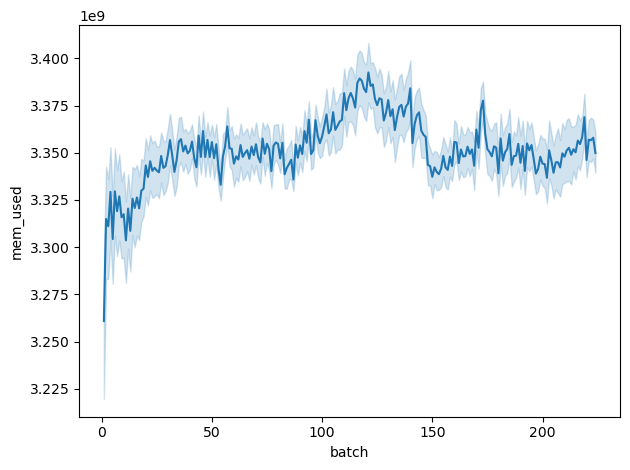

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

t = trainer.timer.benchmarks.reset_index()

fig, ax = plt.subplots()
sns.lineplot(t[t.phase == 'train'], y='mem_used', x='batch')
fig.tight_layout()

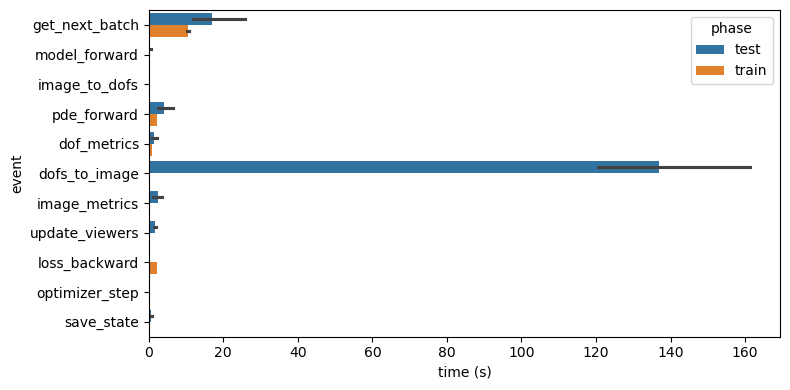

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.benchmarks, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

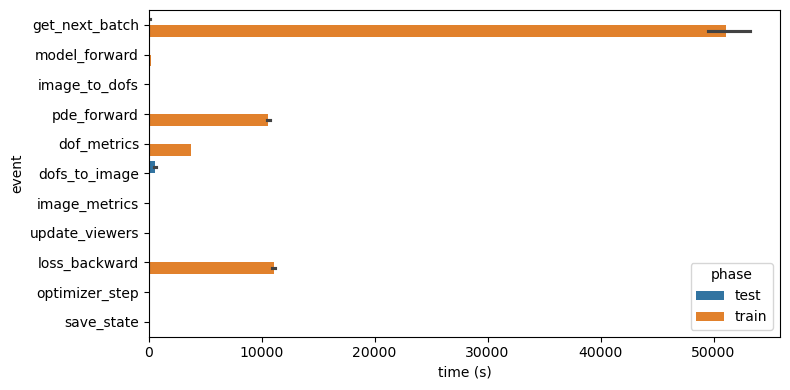

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.benchmarks , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

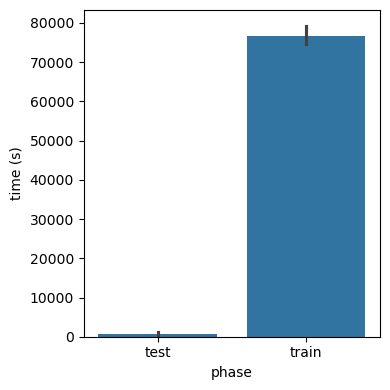

In [24]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.benchmarks, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
test_data[0][-5].mean()

In [ ]:
%pwd